In [1]:
import numpy as np
import json

from FLKutils2 import plot_data, return_best_chi2dof, plot_ref_data
from scipy.special import logsumexp
from scipy.stats import norm

from matplotlib import pyplot as plt
from matplotlib import container

## nplm-fuse

In [33]:
ref_folder = "/home/marcol/nplm-fuse/output_1d/Ntoys1000_NR200000_NB2000_null/"
data_folder = "/home/marcol/nplm-fuse/output_1d/Ntoys300_NR20000_NB2000_NS10_loc6.4_std0.16"

In [34]:
ref = np.load(ref_folder+"/t_array.npy")
data = np.load(data_folder+"/t_array.npy")

In [39]:
def emp_p_value(ref,data,right=True):
    #for idx,el in enumerate(t):
    #    p[idx] = np.mean(ref>=t)
    #if right : p = np.array([np.mean(ref>=t) for t in data])
    if right : p = np.array([(np.count_nonzero(ref >= t)+1) / (len(ref)+1) for t in data])
    else : p = np.array([np.mean(ref<=t) for t in data])
    #p[p==0] = 1/len(ref)
    return p

def p_to_z(pvals):
    return norm.ppf(1 - pvals)

def Zscore(ref,data):
    return p_to_z(emp_p_value(ref,data))

def power(t_ref,t_data, alpha=np.array([0.309,0.159,0.06681,0.0228,0.00620]), right=True):
    # alpha values approx corresponding to Z=.5,1,2,2.5
    if right: quantiles = np.quantile(t_ref,1-alpha)
    else: quantiles = np.quantile(t_ref,alpha)
    return p_to_z(alpha), emp_p_value(t_data,quantiles, right=right)
    

def fusion(x,T):
    return T * logsumexp(1/T*x, axis=1, b=1/x.shape[1])

def fused_t(ref,data,T):
    fused_ref = fusion(ref,T)
    fused_data = fusion(data,T)

    return emp_p_value(fused_ref,fused_data)

def bootstrap_pn(pn,seed=None):
    rnd = np.random.default_rng(seed=seed)
    return rnd.choice(pn,size=len(pn))

def bootstrap_pval(pn,t,seed=None):

    p = np.mean(bootstrap_pn(pn,seed=seed)<=t)

    return p if p > 0 else 1/(len(pn)+1)

    return 

def min_p(ref,data):
    # ref: nxd numpy array
    # data: mxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    p_ref[p_ref == 0] = 1/ref.shape[0]
    p_data[p_data == 0] = 1/ref.shape[0]


    return -np.log(np.min(p_ref,axis=1)), -np.log(np.min(p_data,axis=1))

def fused_p(ref,data,T=1):
    # ref: n_refxd numpy array
    # data: n_dataxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    # empirical p-values for reference toys with a bootstrap approach
    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    # empirical p-values of data
    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    p_ref[p_ref == 0] = 1/ref.shape[0]
    p_data[p_data == 0] = 1/ref.shape[0]

    #return np.min(p_ref,axis=1), np.min(p_data,axis=1)
    return -np.log(-T * logsumexp(-1/T*p_ref, axis=1, b=1/p_ref.shape[1])), -np.log(-T * logsumexp(-1/T*p_data, axis=1, b=1/p_data.shape[1]))


In [40]:
# [0.1, 0.3, 0.7, 1.4, 2.4, 3.0]
for i in range(ref.shape[1]):
    print(np.median(Zscore(ref[:,i],data[:,i])))

2.4334513582784223
2.7481091032295755
2.6524072581155202
2.512497013192562
2.4092803121479585
2.4092803121479585


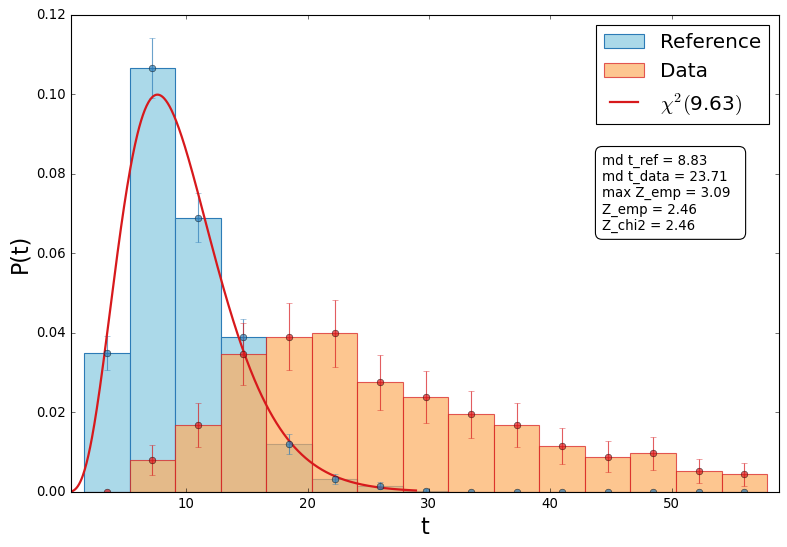

In [41]:
plot_ref_data(ref[:,-2],data[:,-2],bins=15,dof=round(return_best_chi2dof(ref[:10000,-2])[0],2))

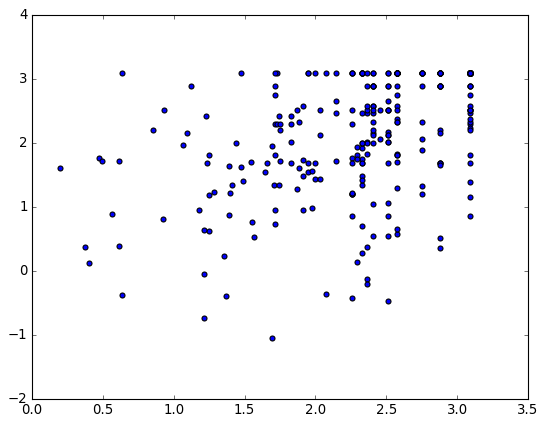

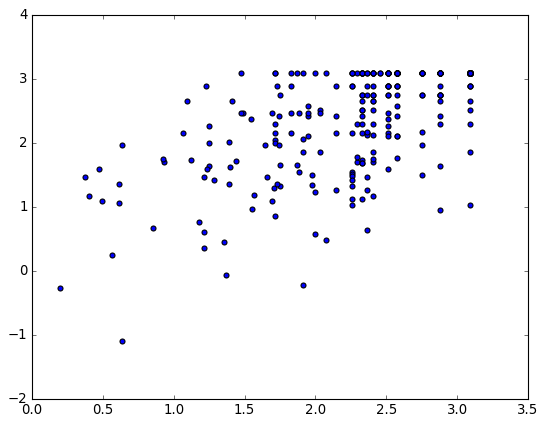

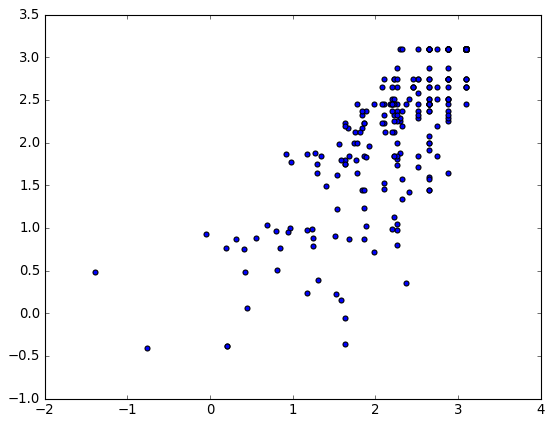

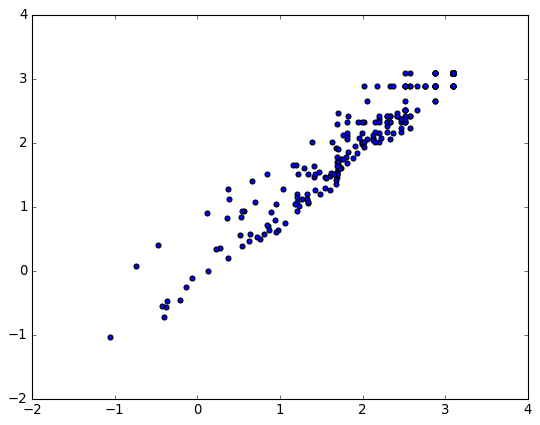

In [42]:
# scatter plots

plt.scatter(Zscore(ref[:,0],data[:,0]),Zscore(ref[:,-1],data[:,-1]))
plt.show()

plt.scatter(Zscore(ref[:,0],data[:,0]),Zscore(ref[:,1],data[:,1]))
plt.show()

plt.scatter(Zscore(ref[:,2],data[:,2]),Zscore(ref[:,3],data[:,3]))
plt.show()

plt.scatter(Zscore(ref[:,-1],data[:,-1]),Zscore(ref[:,-2],data[:,-2]))
plt.show()


In [7]:
for T in [0.001, 1, 10, 1000, 1e5, 1e10]:
    print(np.median(p_to_z((fused_t(ref,data,T)))))

1.5632236468662766
1.5632236468662766
1.5632236468662766
3.090232306167813
3.090232306167813
3.090232306167813


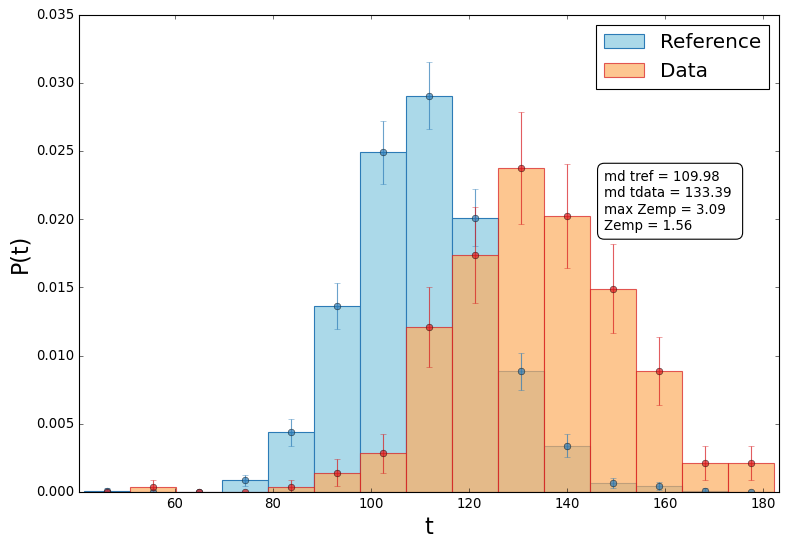

In [8]:
plot_ref_data(fusion(ref,1),fusion(data,1),bins=15)

In [9]:
pmin_ref, pmin_data =  min_p(ref,data)

In [10]:
np.abs(np.median(Zscore(pmin_ref,pmin_data)))

2.5758293035489004

In [11]:
pvals_min_p_ref = []
for idx, el in enumerate(np.transpose(pmin_ref)):
        pvals_min_p_ref.append(bootstrap_pval(np.delete(pmin_ref,idx),el))
#pvals_ref_min = [bootstrap_pval(np.delete(col,idx),el) for el in col]
        
pvals_min_p_data = emp_p_value(pmin_ref,pmin_data)

In [12]:
np.max(pvals_min_p_ref)

1.0

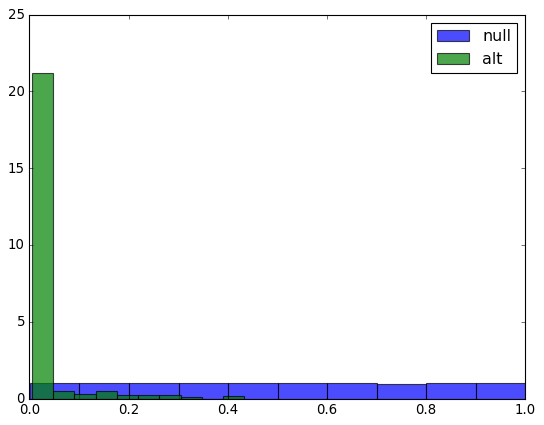

In [13]:
plt.hist(pvals_min_p_ref,bins=10,density=True, alpha=0.7,  label='null')
plt.hist(pvals_min_p_data,bins=10,density=True, alpha=0.7, label='alt')
plt.legend(loc=0)
plt.show()

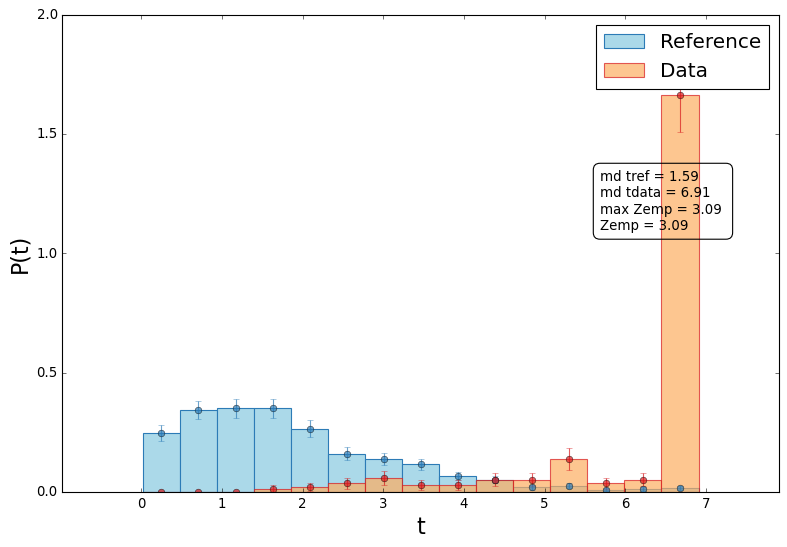

In [14]:
plot_ref_data(pmin_ref,pmin_data,bins=15)

In [15]:
for T in [1e-3, 0.1, 1, 100, 1000]:
    fused_p_ref, fused_p_data = fused_p(ref,data,T)
    print(np.abs(np.median(Zscore(fused_p_ref,fused_p_data))))

3.090232306167813
3.090232306167813
2.878161739095483
2.878161739095483
3.090232306167813


In [16]:
pvals_fused_p_ref = []
for idx, el in enumerate(np.transpose(fused_p_ref)):
        pvals_fused_p_ref.append(bootstrap_pval(np.delete(fused_p_ref,idx),el))
pvals_fused_p_ref = np.array(pvals_fused_p_ref)
pvals_fused_p_ref[pvals_fused_p_ref==0.]=0.001
pvals_fused_p_ref = -np.log(pvals_fused_p_ref)

In [17]:
np.count_nonzero(pvals_fused_p_ref)

998

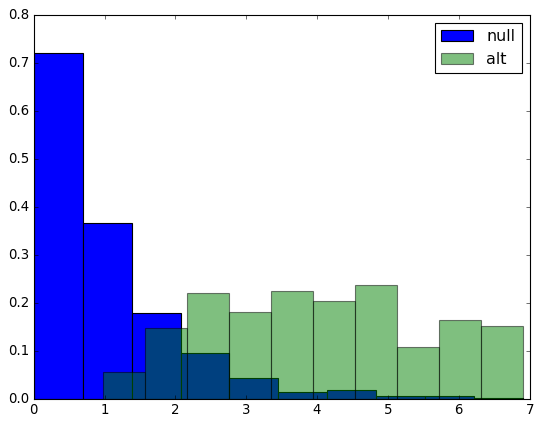

In [18]:
plt.hist(pvals_fused_p_ref,bins=10,density=True, label='null')
plt.hist(fused_p_data,bins=10,density=True, alpha=0.5, label='alt')
plt.legend(loc=0)
plt.show()

In [19]:
fused_p_ref, fused_p_data = fused_p(ref,data)
print(
    power(fusion(ref,1),fusion(data,1))[1],
    power(pmin_ref,pmin_data)[1],
    power(fused_p_ref,fused_p_data)[1],
    )

[0.83666667 0.72666667 0.52333333 0.31666667 0.13666667] [0.99333333 0.94333333 0.91666667 0.86       0.76333333] [1.         0.97666667 0.94       0.85666667 0.70333333]


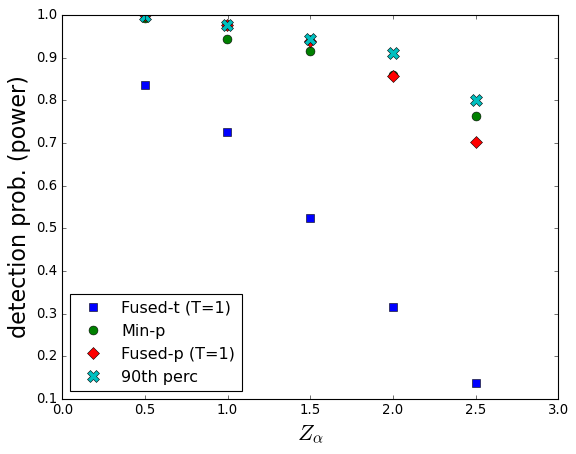

In [20]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.legend(numpoints=1, loc='best')
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

## nplm-avg

In [150]:
ref_avg = np.load(ref_folder+"/t_avg_array.npy")
data_avg = np.load(data_folder+"/t_avg_array.npy")

ref_avg_exp = np.load(ref_folder+"/t_avg_exp_array.npy")
data_avg_exp = np.load(data_folder+"/t_avg_exp_array.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/home/marcol/nplm-fuse/output_1d/Ntoys100_NR200000_NB2000_NS90_loc1.6_std0.16/t_avg_array.npy'

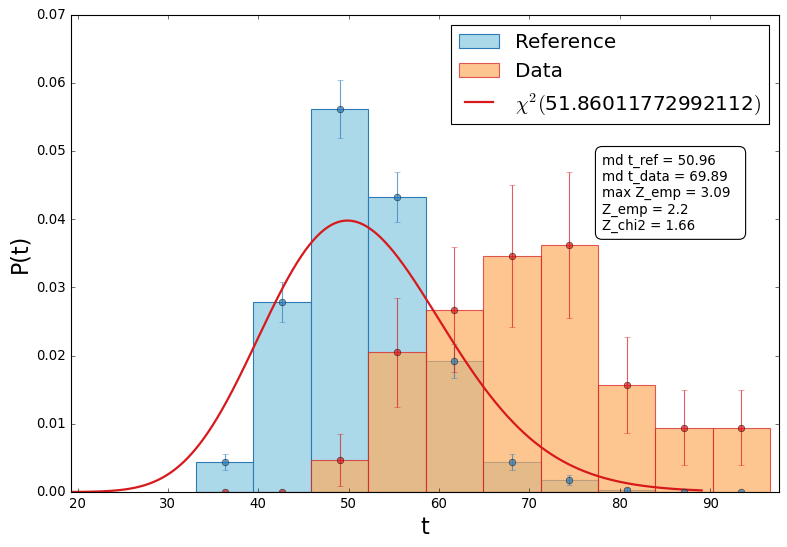

In [151]:
plot_ref_data(ref_avg,data_avg,dof=return_best_chi2dof(ref_avg[:50000])[0])

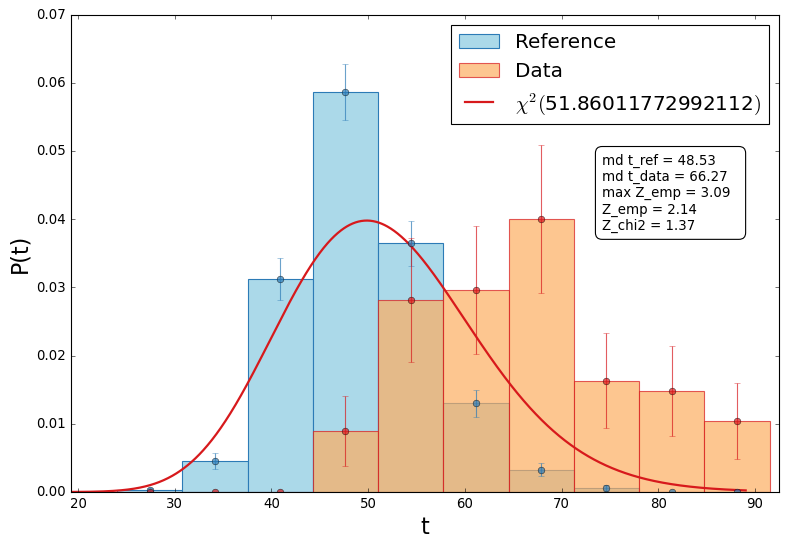

In [152]:
plot_ref_data(ref_avg_exp,data_avg_exp,dof=return_best_chi2dof(ref_avg[:50000])[0])

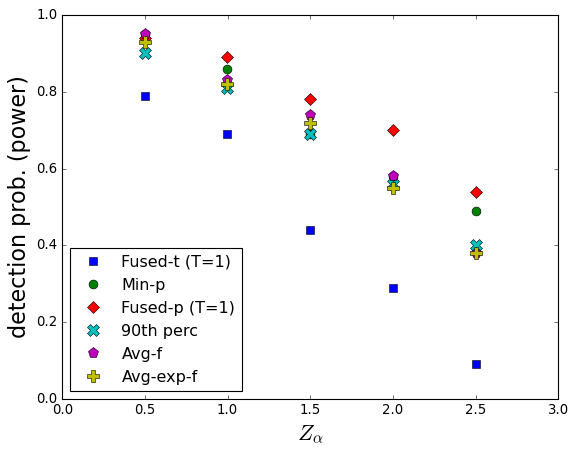

In [153]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg,data_avg)[1],label='Avg-f',linestyle='None',marker='p',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg_exp,data_avg_exp)[1],label='Avg-exp-f',linestyle='None',marker='P',ms=10)
plt.legend(numpoints=1, loc='best')
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

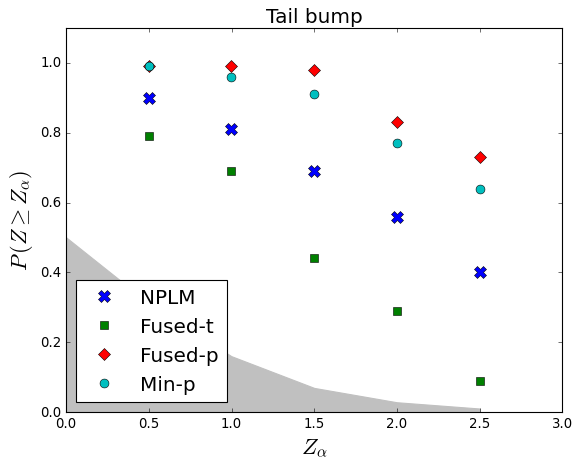

In [202]:
#plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.title("Bulk bump", fontsize=18)
plt.errorbar(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='NPLM',linestyle='None',marker='X',ms=10)
plt.errorbar(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t',linestyle='None',marker='s',ms=8)
plt.errorbar(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p',linestyle='None',marker='D',ms=8)
plt.errorbar(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
#plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg,data_avg)[1],label='Avg-f',linestyle='None',marker='p',ms=10)
#plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg_exp,data_avg_exp)[1],label='Avg-exp-f',linestyle='None',marker='P',ms=10)
plt.fill_between([0,0.49868686, 0.99857627, 1.49997839, 1.99907721, 2.50055179],[0.5,0.312, 0.16 , 0.069, 0.028, 0.01 ],color='silver')
plt.legend(numpoints=1, loc=3,fontsize=18)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel(r'$P\,(Z\geq Z_\alpha)$', fontsize=20)
plt.ylim((0,1.1))
plt.show()

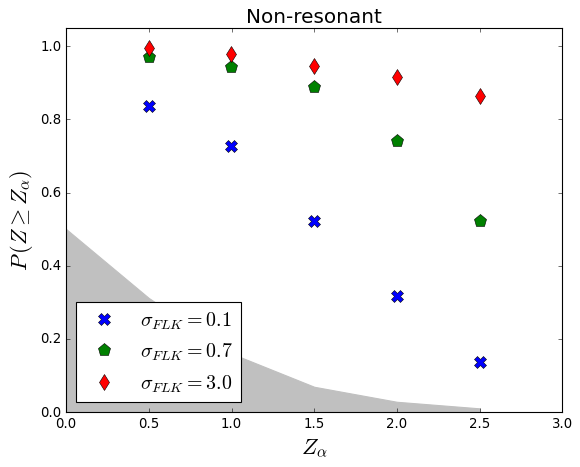

In [240]:
plt.title("Non-resonant", fontsize=18)
plt.errorbar(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,0],data[:,0])[1],label=r'$\sigma_{FLK}=0.1$',linestyle='None',marker='X',ms=10)
plt.errorbar(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,2],data[:,2])[1],label=r'$\sigma_{FLK}=0.7$',linestyle='None',marker='p',ms=12)
plt.errorbar(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,5],data[:,5])[1],label=r'$\sigma_{FLK}=3.0$',linestyle='None',marker='d',ms=10)
#plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg,data_avg)[1],label='Avg-f',linestyle='None',marker='p',ms=10)
#plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg_exp,data_avg_exp)[1],label='Avg-exp-f',linestyle='None',marker='P',ms=10)
plt.fill_between([0,0.49868686, 0.99857627, 1.49997839, 1.99907721, 2.50055179],[0.5,0.312, 0.16 , 0.069, 0.028, 0.01 ],color='silver')
plt.legend(numpoints=1, loc=3,fontsize=18)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel(r'$P\,(Z\geq Z_\alpha)$', fontsize=20)
plt.ylim((0,1.05))
plt.show()

## export tests

In [74]:
#np.save(ref_folder+"/p_min.npy", pmin_ref)
#np.save(ref_folder+"/t_fused_1.npy", fusion(ref,1))
#np.save(ref_folder+"/p_fused_1.npy", fused_p_ref)

In [75]:
np.save(data_folder+"/p_min.npy", pmin_data)
np.save(data_folder+"/t_fused_1.npy", fusion(data,1))
np.save(data_folder+"/p_fused_1.npy", fused_p_data)

## tests

In [44]:
def errors(powers,data):
    return powers*np.sqrt(1./(np.array(powers)*len(data))+1./len(data))

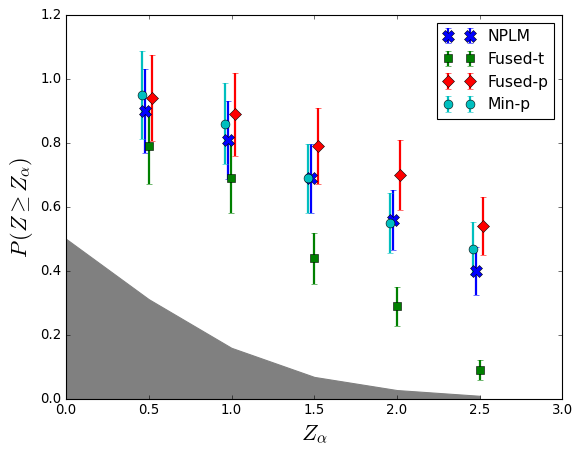

In [128]:
Z_a = [0.49868686, 0.99857627, 1.49997839, 1.99907721, 2.50055179]

plt.errorbar(np.array(Z_a)-0.02,power(ref[:,-2],data[:,-2])[1],yerr=errors(power(ref[:,-2],data[:,-2])[1],data[:,-2]),label='NPLM',linestyle='None',marker='X',ms=10,lw=2)
plt.errorbar(np.array(Z_a),power(fusion(ref,1),fusion(data,1))[1],yerr=errors(power(fusion(ref,1),fusion(data,1))[1],fusion(data,1)),label='Fused-t',linestyle='None',marker='s',ms=8,lw=2)
plt.errorbar(np.array(Z_a)+0.02,power(fused_p_ref,fused_p_data)[1],yerr=errors(power(fused_p_ref,fused_p_data)[1],fused_p_data),label='Fused-p',linestyle='None',marker='D',ms=8,lw=2)
plt.errorbar(np.array(Z_a)-0.04,power(pmin_ref,pmin_data)[1],yerr=errors(power(pmin_ref,pmin_data)[1],pmin_data),label='Min-p',linestyle='None',marker='o',ms=8,lw=2)
plt.fill_between([0]+Z_a,[0.5,0.312, 0.16 , 0.069, 0.028, 0.01 ],color='grey')
plt.legend(numpoints=2, loc='best',fontsize=14)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel(r'$P\,(Z\geq Z_\alpha)$', fontsize=20)
plt.show()

In [ ]:
ERRORS = POWERS*np.sqrt(1./(np.array(POWERS)*len(data[name]))+1./len(data[name]))

In [38]:
emp_p_value(ref[:,-2],data[:,-2])

array([0.687, 0.001, 0.376, 0.001, 0.044, 0.016, 0.048, 0.019, 0.001,
       0.005, 0.481, 0.001, 0.048, 0.309, 0.246, 0.246, 0.001, 0.001,
       0.085, 0.009, 0.128, 0.016, 0.025, 0.001, 0.174, 0.044, 0.001,
       0.244, 0.007, 0.001, 0.001, 0.713, 0.007, 0.055, 0.001, 0.023,
       0.131, 0.001, 0.001, 0.008, 0.001, 0.144, 0.047, 0.001, 0.214,
       0.001, 0.015, 0.001, 0.001, 0.231, 0.009, 0.015, 0.001, 0.009,
       0.027, 0.007, 0.346, 0.016, 0.146, 0.307, 0.001, 0.003, 0.015,
       0.019, 0.001, 0.039, 0.001, 0.053, 0.117, 0.001, 0.001, 0.284,
       0.001, 0.095, 0.146, 0.073, 0.001, 0.001, 0.001, 0.053, 0.001,
       0.018, 0.244, 0.08 , 0.001, 0.14 , 0.031, 0.376, 0.001, 0.064,
       0.001, 0.001, 0.001, 0.377, 0.001, 0.739, 0.001, 0.345, 0.001,
       0.117])

In [37]:
power(ref[:,-2],data[:,-2])[1]

array([0.9 , 0.81, 0.69, 0.56, 0.4 ])

In [99]:
seeds_1 = np.loadtxt("/home/marcol/nplm-fuse/output_1d/Ntoys300_NR200000_NB2000_NS90_nonres/seeds.txt",dtype=int)

In [100]:
seeds_2 = np.loadtxt("/home/marcol/nplm-fuse/output_1d/Ntoys100_NR200000_NB2000_NS13_loc4_std0.64/seeds.txt")

In [104]:
np.in1d(seeds_2, seeds_1)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])